In [1]:
import pandas as pd
# import packages (some of this is from the liet library)
import sys
sys.path.append('/Users/geba9152/LIET/liet/')
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import rnap_lib_data_proc as dp
from liet_res_class import FitParse
import numpy as np
import time
from collections import OrderedDict
import rnap_lib_data_proc as dp

Date: 5/8/2024

Objective: Looking at biological variation in the location of mT

Plots/workflow for understanding this variation within/across cell types
1. Look at all fits across replicates/metas, code to do this is here ``06_ground-truth-liet-visualizations`` from spring 2024 folder
2. mT per rep within a given cell type per gene
3. all mTs in a scatter plot


   ```  CDKN2AIP|NM_017632.4 
        DUSP2|NM_004418.4 
        HNRNPA0|NM_006805.4 
        ID2|NM_002166.5 
        LBH|NM_030915.4 
        NDUFS5|NM_004552.3 
        RHOB|NM_004040.4 
        RNF187|NM_001010858.3 
        SPCS3|NM_021928.4 
        TMSB10|NM_021103.4 ```
        
 ** note tight-sT is the most optimal ref point for all ground truth genes **
 
 ## FINAL GENES TO REMOVE LIST (FOUND A COUPLE MORE AFTER MADE THE ONE ABOVE)
```
DUSP2|NM_004418.4
HNRNPA0|NM_006805.4
ID2|NM_002166.5
LBH|NM_030915.4
NDUFS5|NM_004552.3
RHOB|NM_004040.4
RNF187|NM_001010858.3
SPCS3|NM_021928.4
TMSB10|NM_021103.4
OMA1|NM_145243.5
MIR181A1HG|NR_040073.1 ```

In [2]:
# create iterb to iterate over
batch_names = ['hct116-batch','hela-batch','k562-batch','hek239-batch']

# batch_names = ['beas2b-batch']
iterb = pd.DataFrame(batch_names, columns=['batch'])

cell_types = ['HCT116', 'HeLa', 'K562', 'HEK239T-HEK239']
iterb['cell type'] = cell_types

iterb

,batch,cell type
0,hct116-batch,HCT116
1,hela-batch,HeLa
2,k562-batch,K562
3,hek239-batch,HEK239T-HEK239


In [13]:
# getting a list of genes to loop through ##
# Load the data
ann = pd.read_csv("/scratch/Users/geba9152/LIET-spring2024/meta-celltype-uT-comparison-liet/annotation/lietanns/chr1-6-3p-UTR.liet.ann", sep="\t", header=None, names=["chr", "start", "stop", "gene", "length", "strand"])
pad = pd.read_csv("/scratch/Users/geba9152/LIET-spring2024/meta-celltype-uT-comparison-liet/annotation/pads/chr1-6-3p-UTR.pad", sep="\t", header=None, names=["gene", "pad"])

# Split the 'pad' column into 'left-pad' and 'right-pad'
pad[['left-pad', 'right-pad']] = pad['pad'].str.split(",", expand=True)

# Merge the ann and pad dataframes
ann = ann.merge(pad, on='gene')

# List of genes to remove
genestoremove = ['DUSP2|NM_004418.4', 'HNRNPA0|NM_006805.4', 'ID2|NM_002166.5',
                 'LBH|NM_030915.4', 'NDUFS5|NM_004552.3', 'RHOB|NM_004040.4',
                 'RHOB|NM_004040.4', 'RNF187|NM_001010858.3', 'SPCS3|NM_021928.4', 
                 'TMSB10|NM_021103.4', 'OMA1|NM_145243.5','MIR181A1HG|NR_040073.1']
print(len(ann))

# Remove specific genes
ann = ann[~ann['gene'].isin(genestoremove)]

# convert the 'gene' column to a list 
genes = ann['gene'].unique().tolist()
len(genes)

163


152

### Sample processing function modifed from Jacob's script

In [14]:
def results_loader(gene_ids, result, log):
    '''
    This function is adapted from Jacob's function in rnap_lib_fitting_results
    
    His notes: 
    This function reads in LIET fitting results from .liet and .liet.log files,
    extracting only model parameters for specified gene IDs.
    '''
    results = OrderedDict()
    try:
        # Fit results files
        fit_parse = FitParse(result, log_file=log)

        # Format and consolidate all the results for return
        for gid in gene_ids:
            if gid in fit_parse.genes:
                model_params = {p: v[0] for p, v in fit_parse.fits[gid].items()}
                results[gid] = model_params
            else:
                print(f"Gene {gid} not found in fit result for file: {result}")
    except Exception as e:
        # Handle any errors that occur during the FitParse initialization or processing
        print(f"Failed to process file: {result} with error: {e}")
        # Optionally, log the error or take other actions

    return results

## Pulling out mT and sT from individual samples per batch

In [15]:
def pull_out_params_individual_samples(refpoint):
    
    # set a base path
    base_path = "/scratch/Users/geba9152/LIET-spring2024/"
    
    # pass a list of gebes
    gene_list = genes
    
    # dictionary to store results
    results_dict = {}  
    
    # loop through iterb table to get batches
    for index, row in iterb.iterrows():
        batch = row['batch']
        print(f"Processing batch: {batch}")
        
        # define paths
        lietpath = f"{base_path}{batch}/results/{refpoint}/*.liet"
        logpath = f"{base_path}{batch}/results/{refpoint}/*.liet.log"
        configpath = f"{base_path}{batch}/config/{refpoint}/*.liet.config"
        
        # get list of files for each type
        lietfiles = glob.glob(lietpath)
        logfiles = glob.glob(logpath)
        configfiles = glob.glob(configpath)
        
        # initialize the batch in the dictionary if not already present
        if batch not in results_dict:
            # add batch as a key
            results_dict[batch] = {}

        # Loop through each group of files (files specialized to each srr)
        for configfile, lietfile, logfile in zip(configfiles, lietfiles, logfiles):
            
            # extract SRR number from filename
            srr_number = os.path.basename(lietfile).split('.')[0] 
            
            # call results loader function to parse results file
            gene_results = results_loader(gene_list, result=lietfile, log=logfile)
            
            # check the SRR entry is initialized in the batch
            if srr_number not in results_dict[batch]:
                
                # add in SRR entry to dictionary
                results_dict[batch][srr_number] = {}

            # iterate through each gene to extract results
            for gene_id in gene_list:
                if gene_id in gene_results:
                    
                    # gene_results is the dictionary that is outputted via the results_loader function
                    gene_info = gene_results[gene_id]  

                    # Extract the parameters from "gene_info"
                    mT = gene_info.get("mT", None)
                    sT = gene_info.get("sT", None)
                    mL = gene_info.get("mL", None)
                    sL = gene_info.get("sL", None)

                    # initialize gene in results_dict under the current SRR if not already present
                    if gene_id not in results_dict[batch][srr_number]:
                        results_dict[batch][srr_number][gene_id] = []

                    # append the mT and sT for each gene per SRR per batch
                    results_dict[batch][srr_number][gene_id].append({'mT': mT, 'sT': sT, 'mL': mL, 'sL': sL })
    
    return results_dict

# run function 
refpoint = "tight-sT"
samp_results_dict = pull_out_params_individual_samples(refpoint)

## NOTES:
# results dict is a dict that has keys associated with SRRs per each cell type batch & associated mT/sT vals

Processing batch: hct116-batch
Processing batch: hela-batch
Processing batch: k562-batch
Gene MYSM1|NM_001085487.3 not found in fit result for file: /scratch/Users/geba9152/LIET-spring2024/k562-batch/results/tight-sT/SRR12083664.liet
Failed to process file: /scratch/Users/geba9152/LIET-spring2024/k562-batch/results/tight-sT/SRR5364303.liet with error: 'MYSM1|NM_001085487.3'
Processing batch: hek239-batch


## Pull out mT and sT from metas

In [16]:
def pull_out_params_meta_samples(refpoint):
    
    # set base path
    base_path = "/scratch/Users/geba9152/LIET-spring2024/meta-celltype-uT-comparison-liet/"
    
    # pull in the list of genes
    gene_list = genes
    results_dict = {}  # initialize dictionary to store the results

    # define paths
    lietpath = f"{base_path}/results/{refpoint}/*.liet"
    logpath = f"{base_path}/results/{refpoint}/*.liet.log"
    configpath = f"{base_path}/config/{refpoint}/*.liet.config"

    # get list of files for each type
    lietfiles = glob.glob(lietpath)
    logfiles = glob.glob(logpath)
    configfiles = glob.glob(configpath)

    # process each group of files 
    for configfile, lietfile, logfile in zip(configfiles, lietfiles, logfiles):
        srr_number = os.path.basename(lietfile).split('.')[0]  # extract celltype from filename
        
        # call results_loader function to get model params
        gene_results = results_loader(gene_list, result=lietfile, log=logfile)

        # initialize celltype is initialized in dictionary
        # here it is labeled as srr because I am lazy & copied from code above
        if srr_number not in results_dict:
            results_dict[srr_number] = {}

        # iterate through each gene to extract results
        for gene_id in gene_list:
            if gene_id in gene_results:
                
                # gene results are model params outputted by jacob's function 
                gene_info = gene_results[gene_id]  

                # extract the parameters directly by key (mT/sT)
                mT = gene_info.get("mT", None)
                sT = gene_info.get("sT", None)
                mL = gene_info.get("mL", None)
                sL = gene_info.get("sL", None)

                # initialize gene in results_dict under the current celltype if not already present
                if gene_id not in results_dict[srr_number]:
                    results_dict[srr_number][gene_id] = []

                # append the mT, mT stdev, and sT for each gene per celltype per batch
                results_dict[srr_number][gene_id].append({'mT': mT, 'sT': sT, 'mL': mL, 'sL': sL})
    
    return results_dict

# run function 
refpoint = "tight-sT/"
meta_results_dict = pull_out_params_meta_samples(refpoint)

## NOTES:
# results dict is a dict that has keys associated with meta cell types & associated mT/sT vals

## Create dfs 
### 1. Batch dfs

In [18]:
def create_dataframes_batch(gene_dict):
    
    # initialize batch dictionary
    batch_dfs = {}
    
    # loop through batches/srrs per results_dictionary
    for batch, srr_data in gene_dict.items():
        
        # prepare a list to store each row of the DataFrame
        data = []
        
        # aggregate data by gene across SRRs (initialize a dictionary to do this)
        gene_aggregate = {}
        
        # for every gene in an srr ...
        for srr, genes in srr_data.items():
            
            # for params in every gene ...
            for gene, results in genes.items():
                
                # if gene is not in dictionary add it
                if gene not in gene_aggregate:
                    gene_aggregate[gene] = {'ROI': gene} 
                
                # also add the associated mT/sT values
                for i, result in enumerate(results):
                    
                    # add a key/value pair for each mT/sT value per gene 
                    gene_aggregate[gene][f'{srr}_mT'] = result['mT']
                    gene_aggregate[gene][f'{srr}_sT'] = result['sT']
                    gene_aggregate[gene][f'{srr}_mL'] = result['mL']
                    gene_aggregate[gene][f'{srr}_sL'] = result['sL']

        # create the data list for DataFrame creation
        for gene, values in gene_aggregate.items():
            data.append(values)

        # create DataFrame from data list
        df = pd.DataFrame(data)

        # read annotation data
        lietann = pd.read_csv("/scratch/Users/geba9152/LIET-spring2024/meta-celltype-uT-comparison-liet/annotation/lietanns/chr1-6-3p-UTR.liet.ann", header=None, sep="\t")
        lietann.columns = ["chrm", "start", "stop", "ROI", "length", "strand"]
        lietann = lietann[["ROI", "length"]]
        lietann["length"].astype(float)

        # merge with annotation data to get length of gene
        df = df.merge(lietann, on="ROI")

        # adjust mT values by subtracting the gene length
        for col in df.columns:
            if 'mT' in col:  # Check if column name contains 'mT'
                df[col] = df[col] - df['length']

        # store the DataFrame in the dictionary with the batch as the key
        batch_dfs[batch] = df

    return batch_dfs

# run function 
batch_dfs = create_dataframes_batch(samp_results_dict)

## NOTES:
# batch_dfs is a dict that has param vals (length of gene taken into account) for each prior for each SRR
batch_dfs


{'hct116-batch':                       ROI  SRZ6290507_mT  SRZ6290507_sT  SRZ6290507_mL  \
 0       RPL22|NM_000983.4         531.12         937.28          64.02   
 1     ENO1|NM_001353346.3        3148.48        1726.84          60.27   
 2    UBE4B|NM_001410744.1        3248.73        1072.87          58.87   
 3         SRM|NM_003132.3        1239.47         602.27           9.35   
 4       EFHD2|NM_024329.6        2140.58         950.28          26.34   
 ..                    ...            ...            ...            ...   
 147      NUS1|NM_138459.5        5490.93        7518.09          54.92   
 148     RPS12|NM_001016.4        1908.38         953.03          62.90   
 149    ABRACL|NM_021243.3        1222.69         595.53          24.50   
 150      HECA|NM_016217.3        4288.27        2440.71          48.18   
 151     SF3B5|NM_031287.3        6881.97        1579.86          66.25   
 
      SRZ6290507_sL  SRR8867629_mT  SRR8867629_sT  SRR8867629_mL  \
 0            

### 2. Meta dfs

In [20]:
def create_meta_dataframe(meta_results_dict):
    # list to collect all data
    all_data = []
    
    # iterate over each cell type and their corresponding genes and measurements
    for cell_type, genes in meta_results_dict.items():
        
        # for the params associated with each gene ...
        for gene, measurements in genes.items():
            
            # for each param ...
            for measurement in measurements:
                # create a dictionary for each measurement entry
                data_entry = {
                    'ROI': gene,
                    f'{cell_type}_mT': measurement['mT'],
                    f'{cell_type}_sT': measurement['sT'],
                    f'{cell_type}_mL': measurement['mL'],
                    f'{cell_type}_sL': measurement['sL']
                }
                all_data.append(data_entry)
    
    # create a DataFrame from the collected data
    df = pd.DataFrame(all_data)
    
    # aggregate ROIs in prep for merge
    df = df.groupby('ROI').agg({
        col: 'mean' for col in df.columns if col != 'ROI'
    }).reset_index()
    
    # read annotation data
    lietann = pd.read_csv("/scratch/Users/geba9152/LIET-spring2024/meta-celltype-uT-comparison-liet/annotation/lietanns/chr1-6-3p-UTR.liet.ann", header=None, sep="\t")
    lietann.columns = ["chrm", "start", "stop", "ROI", "length", "strand"]
    lietann = lietann[["ROI", "length"]]
    lietann["length"].astype(float)
    
    # merge with annotation data to get length of gene
    df = df.merge(lietann, on="ROI")
    
    # adjust mT values by subtracting the gene length
    for col in df.columns:
        if 'mT' in col:  # Check if column name contains 'mT'
                df[col] = df[col] - df['length']
    
    return df


meta_df = create_meta_dataframe(meta_results_dict)

## NOTES:
# meta_df is a dict that has param vals (length of gene taken into account) for each prior for each meta cell type

In [56]:
meta_df

,ROI,meta_K562_mT,meta_K562_sT,meta_K562_mL,meta_K562_sL,meta_HCT116_mT,meta_HCT116_sT,meta_HCT116_mL,meta_HCT116_sL,meta_HEp2_mT,...,meta_HEp2_sL,meta_HEK239T-HEK239_mT,meta_HEK239T-HEK239_sT,meta_HEK239T-HEK239_mL,meta_HEK239T-HEK239_sL,meta_HeLa_mT,meta_HeLa_sT,meta_HeLa_mL,meta_HeLa_sL,length
0,ABRACL|NM_021243.3,1408.22,568.17,24.67,8.92,1406.37,1208.27,11.21,219.15,1183.81,...,34.87,1308.98,1080.95,18.54,46.91,1551.70,877.11,25.62,38.33,14558
1,ABT1|NM_013375.4,-348.72,1735.12,55.14,6.69,-377.61,1734.99,69.95,21.60,-438.10,...,12.34,135.88,1959.62,50.01,7.80,-228.70,850.82,49.35,10.97,3787
2,ACADM|NM_000016.6,1166.63,661.68,65.76,24.13,2023.80,1457.32,58.12,183.01,-1566.00,...,17.05,1426.26,698.51,18.38,152.19,1449.41,654.26,66.12,21.14,38971
3,ACBD3|NM_022735.4,1138.42,4809.70,77.05,18.03,3997.46,4237.47,77.80,19.93,5243.33,...,18.39,3858.39,4487.41,79.15,16.34,5103.89,4550.12,74.60,15.42,42063
4,AGL|NM_000642.3,2223.97,1030.22,-69.95,162.53,2855.59,1565.51,-13.09,121.77,2793.69,...,199.59,2708.17,1463.60,-68.39,153.02,2671.51,1120.61,-64.26,147.74,73660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,ZNF644|NM_016620.4,22358.54,5692.78,-48.01,448.27,26024.60,6593.57,-65.92,358.07,31444.25,...,440.54,27067.93,7049.64,-53.59,1665.30,23652.53,4101.27,-58.56,1224.48,106180
148,ZNF684|NM_152373.4,1227.69,1041.74,77.14,7.33,1185.45,1495.26,82.29,49.38,948.40,...,25.40,85.53,2062.33,62.05,35.09,1076.13,1004.06,58.17,31.94,16531
149,ZRANB2|NM_203350.3,8182.72,1443.23,36.79,4.74,9095.08,1361.00,79.75,50.08,6870.83,...,6.19,8286.24,2193.65,41.73,8.61,7956.53,1445.68,42.40,6.58,17745
150,ZSCAN20|NM_145238.6,-6003.64,3099.05,31.94,31.77,-4966.24,3852.99,38.26,25.39,-4350.84,...,45.74,-4323.20,3308.66,66.72,23.00,173.18,846.50,52.61,25.79,28999


## 1st lets check out the meta results

In [21]:
def plot_error_bar_mT_sT(data,celltype):
    """Plots an error bar plot where the dot is mT and error bars represent sT."""
    plt.figure(figsize=(14, 8))
    genes = data.index  # Assuming the gene names are the index; if not, adjust accordingly
    mT = data['mT']
    sT = data['sT']
    
    plt.errorbar(x=genes, y=mT, yerr=sT, fmt='o', ecolor='red', capsize=5, linestyle='None', marker='s', color='black')
    plt.xticks(rotation=90)  # Rotate x labels for better readability if needed
    plt.title(f'Mean (mT) and Sigma T per Gene, {celltype}')
    plt.xlabel('Gene')
    plt.ylabel('mT with sT Error Bars')
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()
    
def plot_violin_with_annotations(cell_data_df, column_prefix):
    """
    Plots violin plots with embedded data points for a specified column prefix,
    where the data is given as a DataFrame with multiple columns for different cell types.
    This function also annotates the top 5 and bottom 5 genes directly on the plot 
    for each cell type.

    Parameters:
        cell_data_df (DataFrame): DataFrame where each column represents data for a cell type.
        column_prefix (str): Prefix of the columns to plot (e.g., 'sT', 'mT').
    """
    # Filter columns related to the column_prefix
    relevant_columns = [col for col in cell_data_df.columns if column_prefix in col]
    
    # Melt the DataFrame to long format
    melted_data = pd.melt(cell_data_df, id_vars=['ROI'], value_vars=relevant_columns,
                          var_name='CellType', value_name=column_prefix)
    
    # Clean the 'CellType' to extract only the cell type information
    melted_data['CellType'] = melted_data['CellType'].apply(lambda x: x.split('_')[1])

    plt.figure(figsize=(14, 8))  # Adjust size for annotations

    # Create the violin and strip plots
    ax = sns.violinplot(x='CellType', y=column_prefix, data=melted_data, scale='width', inner=None, palette="husl")
    sns.stripplot(x='CellType', y=column_prefix, data=melted_data, color='k', size=3, jitter=True, alpha=0.5)

    plt.title(f'Violin Plot with Annotations of {column_prefix} Across Cell Types')
    plt.xlabel('Cell Type')
    plt.ylabel(column_prefix)

    ### COMMENT THE CODE BLOCK BELOW OUT IF YOU DON'T WANT ANNOTATIONS !
    
#     # Annotate top and bottom genes
#     grouped = melted_data.groupby('CellType')
#     for name, group in grouped:
#         top_genes = group.nlargest(5, column_prefix)
#         bottom_genes = group.nsmallest(5, column_prefix)

#         # Annotate top genes
#         for i, row in top_genes.iterrows():
#             plt.text(x=name, y=row[column_prefix], s=row['ROI'], horizontalalignment='right', color='green', fontsize=9)

#         # Annotate bottom genes
#         for i, row in bottom_genes.iterrows():
#             plt.text(x=name, y=row[column_prefix], s=row['ROI'], horizontalalignment='left', color='red', fontsize=9)

    plt.xticks(rotation=45)  # Rotate labels if needed
    plt.show()

**Meta function calls**

/Users/geba9152/miniconda3/envs/rpy2_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/geba9152/miniconda3/envs/rpy2_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/geba9152/miniconda3/envs/rpy2_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


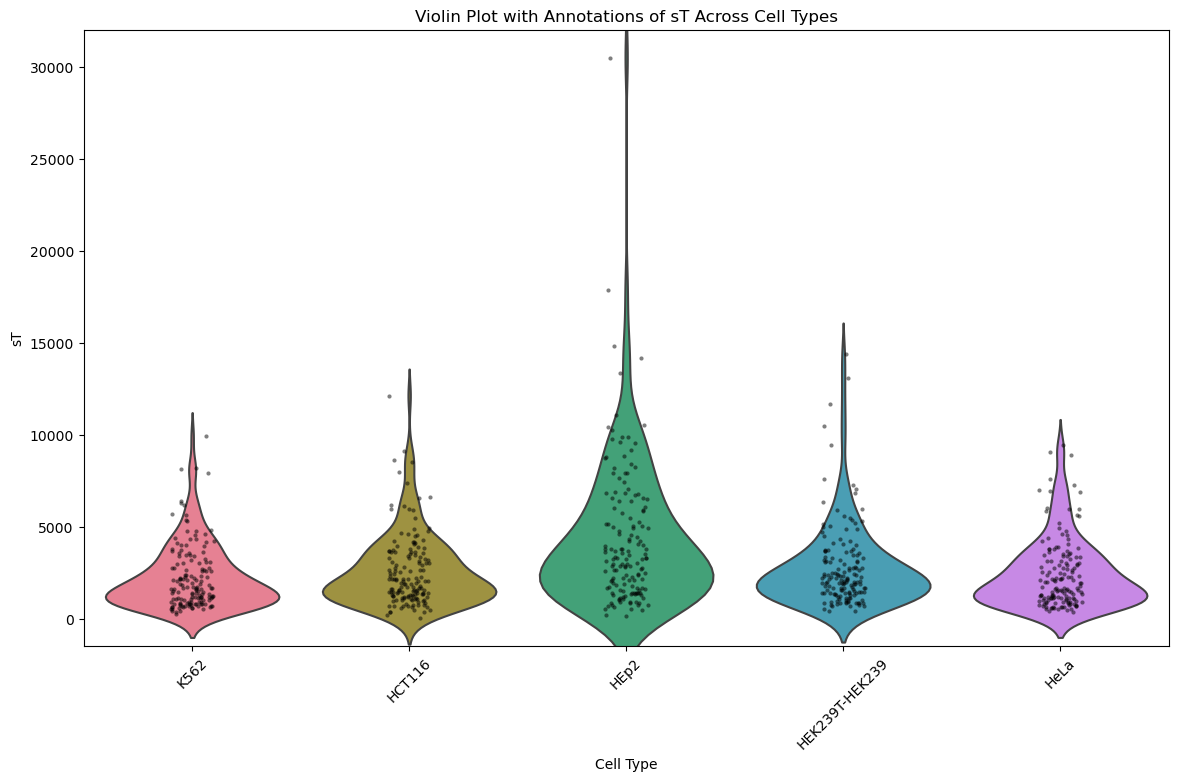

/Users/geba9152/miniconda3/envs/rpy2_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/geba9152/miniconda3/envs/rpy2_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/geba9152/miniconda3/envs/rpy2_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


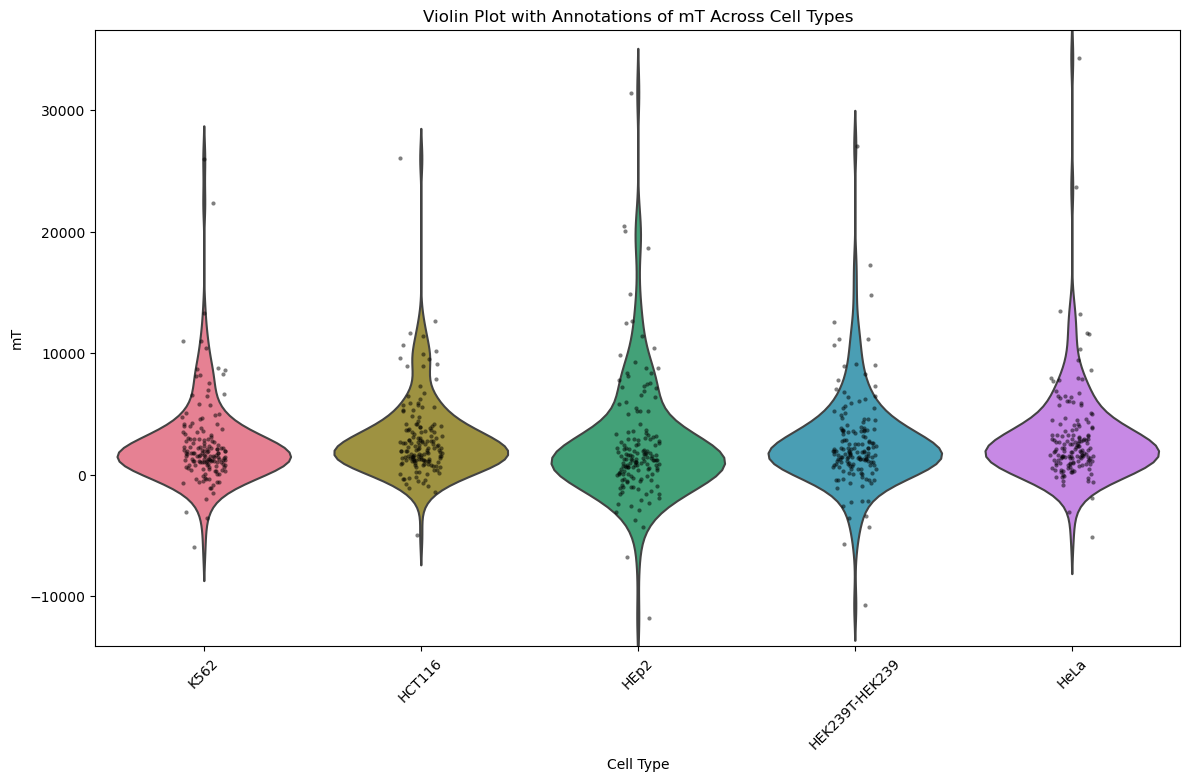

In [22]:
plot_violin_with_annotations(meta_df, 'sT')
plot_violin_with_annotations(meta_df, 'mT')

Notes on metas after the re-run:
1. OMA1 looks good in HCTs & HEps; bad in HeLa/K562 (one to be weary of!)
2. MIR181A1 looks goof in HCT & HeLa; horrid in K562 (not transcribed; drop for this cell type!)
    - Note MIR181A1 would not plot in the HEp2 but is showing up in graph above- so I do not trust it!
    
** adding these genes (OMA1 and MIR18A1 to drop list!!) **


## 2nd lets now see how the individual samples performed!

In [24]:
def plot_merged_batches(batch_dfs, meta_df, iterb, measurement_type):
    """
    Merges multiple batch DataFrames with a meta DataFrame, and plots violin plots with embedded data points
    for a specified measurement type across different cell types. Annotates top and bottom genes on the plot.

    Parameters:
        batch_dfs (dict): Dictionary where each key is a batch name and each value is a DataFrame of that batch.
        meta_df (DataFrame): Meta DataFrame containing measurements across various cell types.
        iterb (DataFrame): DataFrame mapping batch names to cell types.
        measurement_type (str): Type of measurement to plot (e.g., 'mT', 'sT', 'mL', 'sL').
    """
    # Initialize an empty DataFrame to collect all data
    combined_data = pd.DataFrame()

    # Merge each batch DataFrame with the meta DataFrame
    for batch_name, df in batch_dfs.items():
        # Determine the cell type for the current batch
        cell_type = iterb.loc[iterb['batch'] == batch_name, 'cell type'].values[0]
        
        # Filter columns for the relevant measurement type
        relevant_columns = [col for col in df.columns if measurement_type in col]
        relevant_columns.append('ROI')  # Include the ROI for merging
        
        # Merge with meta_df
        merged_df = pd.merge(meta_df[['ROI', f'meta_{cell_type}_{measurement_type}']], df[relevant_columns], on='ROI')
        
        # Rename columns to include the cell type, ensuring uniqueness
        merged_df.columns = [f"{col.split('_')[0]}_{cell_type}" if 'SR' in col else col for col in merged_df.columns]
        
        # Append to combined data
        combined_data = pd.concat([combined_data, merged_df])

    # Melt the DataFrame to long format for plotting
    melted_data = pd.melt(combined_data, id_vars='ROI', var_name='Condition', value_name='Measurement')

    # Plotting
    plt.figure(figsize=(14, 8))
    sns.violinplot(x='Condition', y='Measurement', data=melted_data, scale='width', inner=None, palette="husl")
    ax = sns.stripplot(x='Condition', y='Measurement', data=melted_data, color='k', size=3, jitter=True, alpha=0.5)

    plt.title(f'Violin Plot of {measurement_type} Across Cell Types and Batches')
    plt.xlabel('SRR')
    plt.ylabel('Measurement')
    plt.xticks(rotation=45)

    # Annotate top and bottom genes
    grouped = melted_data.groupby('Condition')
    for name, group in grouped:
        top_genes = group.nlargest(1, 'Measurement')
        bottom_genes = group.nsmallest(1, 'Measurement')

        # Annotate top genes
        for i, row in top_genes.iterrows():
            ax.text(row['Condition'], row['Measurement'], row['ROI'],
                    horizontalalignment='right', color='green', fontsize=9, rotation=45)

        # Annotate bottom genes
        for i, row in bottom_genes.iterrows():
            ax.text(row['Condition'], row['Measurement'], row['ROI'],
                    horizontalalignment='left', color='red', fontsize=9, rotation=45)

    plt.show()
    
    
def plot_mt_values_across_cell_types_errorbar(batch_dfs, meta_df, gene_name, batch_celltype_mapping):
    sns.set(style="white")  # Set plot background to white
    fig, ax = plt.subplots(figsize=(12, 8))  # Create figure and axes
    colors = sns.color_palette("tab10", n_colors=len(batch_dfs))  # Set color palette

    cell_type_labels = []
    means = []
    std_devs = []
    x_positions = np.arange(len(batch_dfs))  # X-axis positions for each cell type

    # Iterate over batch DataFrames
    for idx, (batch_name, df) in enumerate(batch_dfs.items()):
        cell_type = batch_celltype_mapping.get(batch_name)  # Get cell type from mapping
#         print(cell_type)
        if not cell_type:
            continue  # Skip if no mapping exists

        gene_df = df[df['ROI'] == gene_name]  # Filter for specific gene
        if gene_df.empty:
            continue  # Skip if gene not present

        mT_values = [gene_df[col].values[0] for col in gene_df.columns if 'mT' in col]  # Collect mT values

        if mT_values:
            mean_mT = np.mean(mT_values)  # Calculate mean
            std_mT = np.std(mT_values)  # Calculate standard deviation
            means.append(mean_mT)
            std_devs.append(std_mT)
            cell_type_labels.append(cell_type)

    # Plot error bars
    for i, color in enumerate(colors[:len(means)]):
        ax.errorbar(x_positions[i], means[i], yerr=std_devs[i], fmt='o', color=color,
                    ecolor=color, elinewidth=2, capsize=5, markersize=10)

        meta_mT_col = f'meta_{cell_type_labels[i]}_mT'  # Meta column name
        if meta_mT_col in meta_df.columns:
            meta_value = meta_df.loc[meta_df['ROI'] == gene_name, meta_mT_col].values
            if meta_value.size > 0:
                ax.annotate(f'meta mT: {meta_value[0]:.2f}', (x_positions[i], means[i] + std_devs[i]),
                            textcoords="offset points", xytext=(0,10), ha='center')

        ax.annotate(f'avg batch mT: {means[i]:.2f}', (x_positions[i], means[i] - std_devs[i]),
                    textcoords="offset points", xytext=(0,-25), ha='center')

    ax.set_xlabel('Cell Types')
    ax.set_ylabel('mT (Distance From PAS to mT in Bases)')
    ax.set_title(f'mT of Gene: {gene_name} Across Cell Types')
    ax.set_xticks(x_positions[:len(means)])
    ax.set_xticklabels(cell_type_labels)

    plt.show()  # Show plot
#     fig.savefig(savepath + gene_name + "errbar-plts-mT.jpeg", format='jpeg')  # Save figure
    plt.close(fig)  # Close the plot to free memory

def plot_mt_values_across_cell_types(batch_dfs, meta_df, gene_name, batch_celltype_mapping):
    # set plot theme
    sns.set(style="white")
    
    # create a figure and axis object
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # use Seaborn's "tab10" color palette, which provides up to 10 distinct colors
    colors = sns.color_palette("tab10", n_colors=len(batch_dfs))
    color_map = dict(zip(batch_dfs.keys(), colors))

    # data storage for side legend
    summary_data = []

    # iterate over each cell type and its DataFrame
    for color_idx, (batch_name, df) in enumerate(batch_dfs.items()):
        cell_type = batch_celltype_mapping.get(batch_name)
        if not cell_type:
            continue  # If no mapping exists, skip this batch

        # filter the DataFrame for the specific gene
        gene_df = df[df['ROI'] == gene_name]
        
        if gene_df.empty:
            continue  # Skip if the gene is not present in the cell type

        # collect mT values for the gene across different SRRs
        mT_values = [value for column in gene_df.columns if 'mT' in column for value in gene_df[column]]

        # plot data for this gene for the current cell type
        ax.scatter([color_idx] * len(mT_values), mT_values, color=color_map[batch_name], label=cell_type, alpha=0.7, edgecolor='k')
        
        # calculate average mT value if there are any mT values
        if mT_values:
            avg_mT = np.mean(mT_values)
            summary_data.append((f'{cell_type} Batch Avg', avg_mT))

        # fetch the corresponding meta mT value from meta_df
        meta_mT_col = f'{cell_type}_mT'
        if meta_mT_col in meta_df.columns:
            meta_value = meta_df.loc[meta_df['ROI'] == gene_name, meta_mT_col].values
            if meta_value.size > 0:
                summary_data.append((f'{cell_type} Meta', meta_value[0]))

    # annotate the summary data in a table-like format on the side of the plot
    table_text = "\n".join(f"{data[0]}: {data[1]:.2f}" for data in summary_data)
    ax.text(1.03, 0.8, table_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='center', horizontalalignment='left', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'))

    # set labels, legend, and title
    ax.set_xlabel('Cell Types')
    ax.set_ylabel('mT (Distance From PAS to mT in Bases)')
    ax.set_title(f'mT of Gene: {gene_name} Across Cell Types')
    ax.set_xticks(range(len(batch_dfs)))
    
    # label x axis
    ax.set_xticklabels([batch_celltype_mapping.get(name, 'Unknown') for name in batch_dfs.keys()])
    ax.legend(title='Cell Type')

    # show the plot
    plt.show()
    
    # save the figure
#     fig.savefig(savepath + f"{gene_name}_scatter_mT.jpeg", format='jpeg', bbox_inches='tight')
    
    plt.close()
    
batch_celltype_mapping = {
    'hct116-batch': 'HCT116',
    'hela-batch': 'HeLa',
    'k562-batch': 'K562',
    'hek239-batch': 'HEK239T-HEK239'}

** Violins for individual samps **

/Users/geba9152/miniconda3/envs/rpy2_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/geba9152/miniconda3/envs/rpy2_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/geba9152/miniconda3/envs/rpy2_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


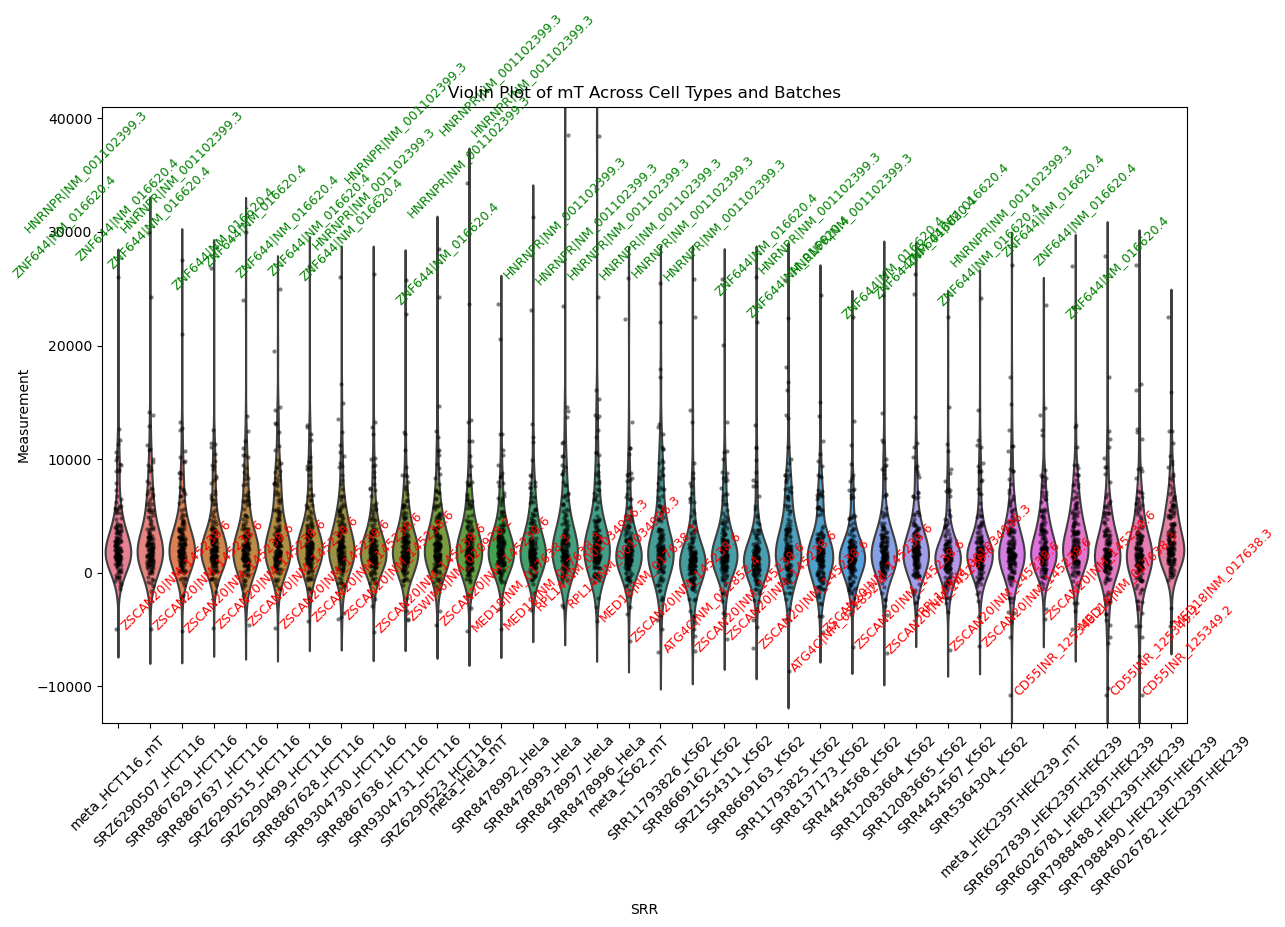

/Users/geba9152/miniconda3/envs/rpy2_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/geba9152/miniconda3/envs/rpy2_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/geba9152/miniconda3/envs/rpy2_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


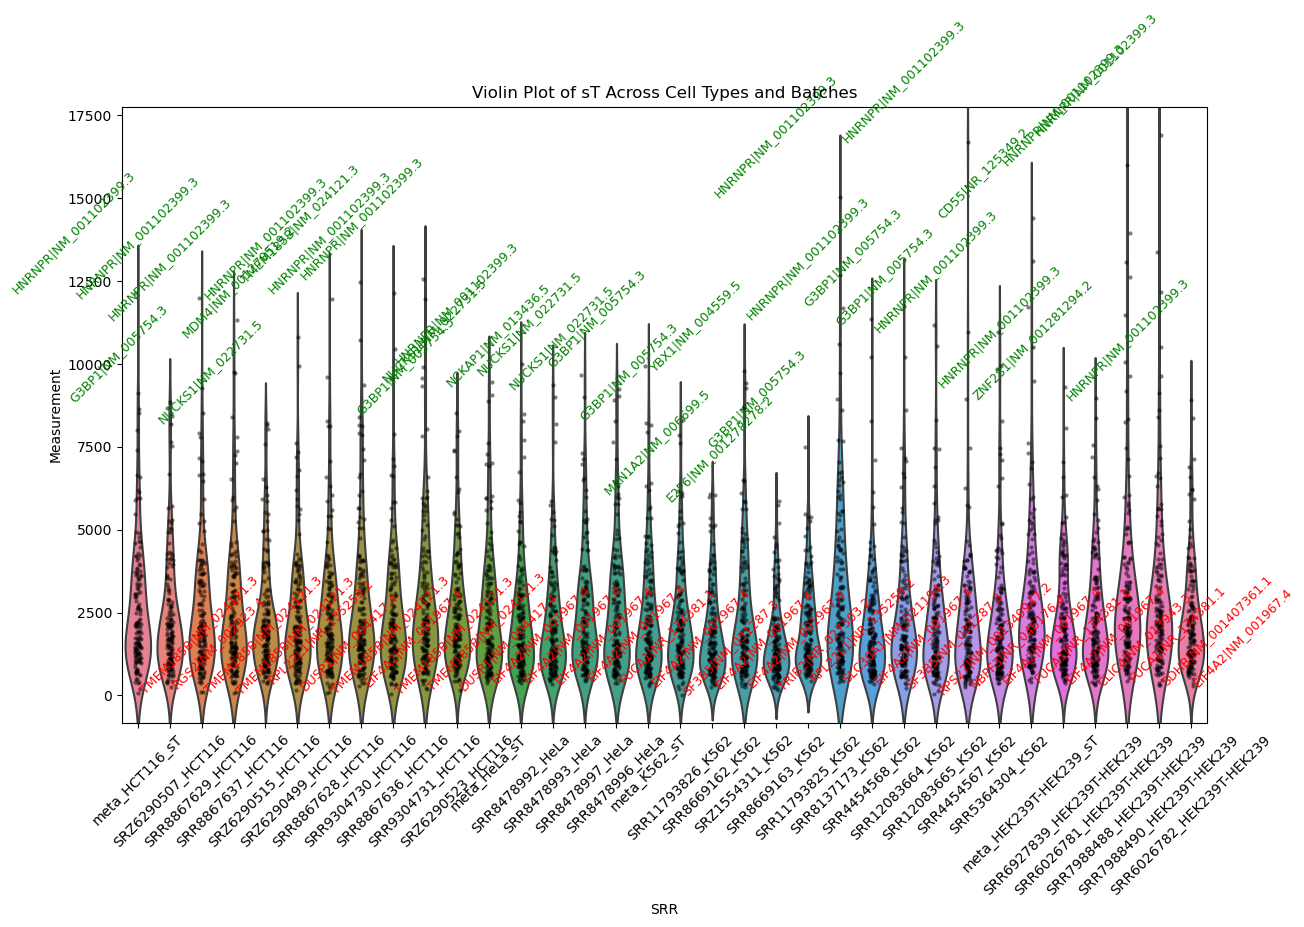

In [25]:
plot_merged_batches(batch_dfs, meta_df, iterb, 'mT')
plot_merged_batches(batch_dfs, meta_df, iterb, 'sT')

### Distributions of mT and sT in replicates & metas look pretty solid- now time to make the Hope plots

Errbar plots include:
1. meta mT as the dot
2. sT as the err line
3. individual replicate values as dots on the plot

** #TODO- submit meta jobs across all cell types! **